<a href="https://colab.research.google.com/github/lszam/potentials-on/blob/main/PosdocON_GravCamposSantosRibeira_Etapa1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ambiente**

##Bibliotecas

In [ ]:
!pip install geopandas shapely matplotlib zipfile36 verde -q

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import shutil
import verde as vd
import requests

from shapely.geometry import Polygon


In [ ]:
!pip install pystac-client pyproj rasterio -q

In [ ]:
import pystac_client
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from shapely.geometry import shape, Polygon, mapping

from pyproj import Transformer, CRS

import rasterio
from rasterio.plot import show
from rasterio.mask import mask

In [ ]:
!apt-get install -y gdal-bin python3-gdal
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
python3-gdal is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
GDAL 3.8.4, released 2024/02/08


In [ ]:
!pip install planetary_computer -q

In [ ]:
!pip install cmocean -q

In [ ]:
import cmocean

###### Função para plotar 2 mapas do Brasil

In [ ]:
def plot_2maps(gdf1, title1, color1, gdf2, title2, color2, brasil_contour):
    """
    Função para plotar dois mapas do Brasil, para situações onde seja necessário comparar dados.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 2 subplots

    # Mapa de pontos que vão ser considerados no projeto
    brasil_contour.plot(ax=axes[0], color='none', edgecolor='black')
    gdf1.plot(ax=axes[0], color=color1, markersize=0.2, alpha=0.6)
    axes[0].set_title(title1, fontsize=16)
    axes[0].set_xlabel('Longitude', fontsize=14)
    axes[0].set_ylabel('Latitude', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].grid(True)

    # Mapa com pontos duplicados, que serão retirados
    brasil_contour.plot(ax=axes[1], color='none', edgecolor='black')
    gdf2.plot(ax=axes[1], color=color2, markersize=0.2, alpha=0.6)
    axes[1].set_title(title2, fontsize=16)
    axes[1].set_xlabel('Longitude', fontsize=14)
    axes[1].set_ylabel('Latitude', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

###### Função para dados espúrios. Correção de caracteres fora do esperado (pontuação de milhar, vírgula, etc).

In [ ]:
def correct_grav_obs_value(value):
    """
    Função para corrigir valores da coluna GRAV_OBS:
    - Remove múltiplos pontos, mantendo apenas o último
    - Substitui vírgulas por pontos
    - Remove caracteres não numéricos
    """
    if pd.isnull(value):
        return value  # Retorna o valor original se for NaN

    # Garantir que o valor é uma string e remover espaços extras
    value = str(value).strip()

    # Substituir vírgulas por pontos
    value = value.replace(',', '.')

    # Se o valor não for uma string válida, retornar None
    if not isinstance(value, str) or value == '':
        return None

    # Corrigir múltiplos pontos, mantendo apenas o último
    if value.count('.') > 1:
        parts = value.split('.')
        value = ''.join(parts[:-1]) + '.' + parts[-1]

    # Converter para float, se possível
    try:
        return float(value)
    except ValueError:
        print ('Erro ao corrigir:', value)
        return None

###### Haversine - distância em coordenadas lat long.

A fórmula Haversine pode ser usada para calcular a distância na esfera. Ela considera a curvatura da terra, mas pressupõe uma terra esférica em vez de um elipsoide. Para longas distâncias, a fórmula Haversine introduz um erro de menos de 0,1%. A altitude não é usada para calcular a distância. Mais em Microsoft Learn https://learn.microsoft.com/pt-br/dotnet/api/system.device.location.geocoordinate.getdistanceto?view=netframework-4.8.1

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula a distância entre dois pontos em km usando a fórmula de Haversine.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Raio médio da Terra em km
    return km

###### Função para encontrar pontos dentro de uma janela de raio específico

In [ ]:
# Função para encontrar pontos dentro de uma janela de raio específico
def find_neighbors(gdf, index, window_size_km):
    """Encontra todos os pontos dentro de uma janela de raio específico em km."""
    lon, lat = gdf.loc[index, ['LONGITUDE', 'LATITUDE']]
    distances = gdf.apply(lambda row: haversine(lon, lat, row['LONGITUDE'], row['LATITUDE']), axis=1)
    neighbors = gdf[distances <= window_size_km]
    return neighbors

In [ ]:
# Baixar o shapefile das unidades da federação (UFs) do Brasil do site do IBGE
'''
!wget -O brasil.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
!unzip brasil.zip -d /content/brasil_shapefile

'''

file_path = '/content/brasil_shapefile/BR_UF_2021.shp'
if os.path.exists(file_path):
  print(f"The file {file_path} already exists.")
else:
  # Baixar o shapefile das unidades da federação (UFs) do Brasil do site do IBGE
  !wget -O brasil.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
  !unzip brasil.zip -d /content/brasil_shapefile
  brasil = gpd.read_file('/content/brasil_shapefile/BR_UF_2021.shp')
  print(f"The file {file_path} was downloaded succesifully.")

brasil = gpd.read_file('/content/brasil_shapefile/BR_UF_2021.shp')

The file /content/brasil_shapefile/BR_UF_2021.shp already exists.


## Configurar área de estudo

Sistema de coordenadas personalizado - policônica com datum sirgas 2000 (EPSG ?)

In [ ]:
from pyproj import CRS

# String do .prj
wkt_string = '''PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]'''

# Criar o objeto CRS a partir do WKT
crs_projeto = CRS.from_wkt(wkt_string)

# Verificar o CRS
print(crs_projeto)

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


In [ ]:
shapefile_path = "janela-ptrII_pg.shp"

#Criar polígono do entorno
aoi_gdf = gpd.read_file(shapefile_path)
aoi_gdf['geometry'] = aoi_gdf['geometry'].buffer(0) # corrige geometrias inválidas com buffer(0)
aoi_gdf = aoi_gdf[aoi_gdf.is_valid & (~aoi_gdf.is_empty)] # apagar feições que ainda estão inválidas

# Verificar CRS
if aoi_gdf.crs is None:
    aoi_gdf = aoi_gdf.set_crs(epsg=crs_projeto)
    print(f"CRS vazio. Definido {crs_projeto}.")
else:
    print(f"CRS original: {aoi_gdf.crs}")
    if aoi_gdf.crs.to_epsg() != crs_projeto:
        aoi_gdf = aoi_gdf.to_crs(epsg=crs_projeto)
        print("Reprojetado.")

CRS original: PROJCS["Polyconic_Brasil",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Polyconic"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-54],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


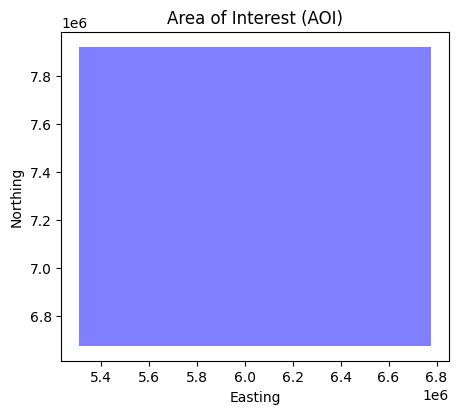

In [ ]:
# Obter limites e montar objeto geoJSON
minx, miny, maxx, maxy = aoi_gdf.total_bounds
coords = [
    [minx, miny],
    [maxx, miny],
    [maxx, maxy],
    [minx, maxy],
    [minx, miny]   # fecha o poligono
]

aoi = {
    "type": "Polygon",
    "coordinates": [coords]
}

# Criar um polígono do entorno e exibir
aoi_polygon = Polygon(aoi['coordinates'][0])
aoi_gdf = gpd.GeoDataFrame(index=[0], geometry=[aoi_polygon])
aoi_gdf = aoi_gdf.set_crs(crs_projeto, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5))
aoi_gdf.plot(ax=ax, color='blue', alpha=0.5)
ax.set_title('Area of Interest (AOI)')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.show()

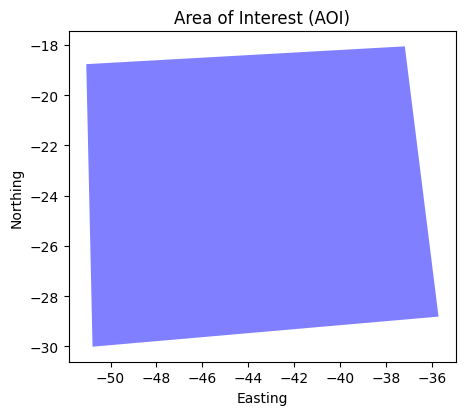

In [ ]:
#Versão em geográfica para pesquisa em catálogos STAC

aoi_gdf_wgs84 = aoi_gdf.to_crs("EPSG:4326")
aoi_gdf_wgs84_geom = aoi_gdf_wgs84.geometry.iloc[0]

fig, ax = plt.subplots(figsize=(5, 5))
aoi_gdf_wgs84.plot(ax=ax, color='blue', alpha=0.5)
ax.set_title('Area of Interest (AOI)')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.show()

# **1. Preparação dos dados gravimétricos e topografia**


##**1.1 Upload e concatenação de dados gravimétricos**

##### **Download de SHPs compactados ([Repositório no Github](https://https://github.com/lszam/gds-ssebrazil/tree/main))**

In [ ]:
# Public data zips
sources = ['https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/bgi_20250221.zip', #BGI L. Szameitat (Use upon authorization and DOI)
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/ibge.zip', # last download: July 2025
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/sgb_20250221.zip', # last download: Feb 2025
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/castro2007.zip',
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/castro2014.zip',
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/barbara-dressel_dgeol-ufpr.zip',
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/renata-zanella_dgeol-ufpr.zip']


# Manual upload - Non-public data
# -----> ON data compilation

# Donwload dos dados zip
for url in sources:
    filename = os.path.join('/content/', url.split('/')[-1])
    try:
        response = requests.get(url, stream=True)
        with open(filename, 'wb') as file:
          for chunk in response.iter_content(chunk_size=8192):
              file.write(chunk)
        print(f"Downloaded {filename} successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")

Downloaded /content/bgi_20250221.zip successfully.
Downloaded /content/ibge.zip successfully.
Downloaded /content/sgb_20250221.zip successfully.
Downloaded /content/castro2007.zip successfully.
Downloaded /content/castro2014.zip successfully.
Downloaded /content/barbara-dressel_dgeol-ufpr.zip successfully.
Downloaded /content/renata-zanella_dgeol-ufpr.zip successfully.


In [ ]:
zip_filenames = []
for url in sources:
  zip_filenames.append(url.split('/')[-1])
file_paths = [os.path.join('/content', url.split('/')[-1]) for url in sources]  # add '/content'
print(f"Caminhos: {file_paths}")

Caminhos: ['/content/bgi_20250221.zip', '/content/ibge.zip', '/content/sgb_20250221.zip', '/content/castro2007.zip', '/content/castro2014.zip', '/content/barbara-dressel_dgeol-ufpr.zip', '/content/renata-zanella_dgeol-ufpr.zip']


##### **Concatenar SHPs**

Descompactar os arquivos

In [ ]:
extract_dir = '/content/SHP/'

os.makedirs(extract_dir, exist_ok=True)
shapefiles = []
for shapefile in file_paths:
    print(shapefile)
    try:
      with zipfile.ZipFile(shapefile, 'r') as zip:
        print(zip)
        zip.extractall(extract_dir)
        # Salvar shapefiles e o nome do arquivo zip como origem
        shapefiles.extend([(os.path.join(extract_dir, name), shapefile)
                              for name in zip.namelist() if name.endswith('.shp')])
    except:
      print(f"Erro ao descompactar {shapefile}")

print(f"Shapefiles resultantes: {shapefiles}")

/content/bgi_20250221.zip
<zipfile.ZipFile filename='/content/bgi_20250221.zip' mode='r'>
/content/ibge.zip
<zipfile.ZipFile filename='/content/ibge.zip' mode='r'>
/content/sgb_20250221.zip
<zipfile.ZipFile filename='/content/sgb_20250221.zip' mode='r'>
/content/castro2007.zip
<zipfile.ZipFile filename='/content/castro2007.zip' mode='r'>
/content/castro2014.zip
<zipfile.ZipFile filename='/content/castro2014.zip' mode='r'>
/content/barbara-dressel_dgeol-ufpr.zip
<zipfile.ZipFile filename='/content/barbara-dressel_dgeol-ufpr.zip' mode='r'>
/content/renata-zanella_dgeol-ufpr.zip
<zipfile.ZipFile filename='/content/renata-zanella_dgeol-ufpr.zip' mode='r'>
Shapefiles resultantes: [('/content/SHP/sgb_20250221.shp', '/content/bgi_20250221.zip'), ('/content/SHP/bgi_20250221.shp', '/content/bgi_20250221.zip'), ('/content/SHP/ibge_fev2025.shp', '/content/ibge.zip'), ('/content/SHP/sgb_20250221.shp', '/content/sgb_20250221.zip'), ('/content/SHP/castro2007.shp', '/content/castro2007.zip'), ('/cont

In [ ]:
zip_files = [
    '/content/anp_lpga.zip',
    '/content/on_bndg.zip',
    '/content/on_iag.zip'
]

for zip_file in zip_files:
    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Extracted {zip_file} to {extract_dir}")
    else:
        print(f"Error: {zip_file} not found.")

print("Extraction complete.")

Extracted /content/anp_lpga.zip to /content/SHP/
Extracted /content/on_bndg.zip to /content/SHP/
Extracted /content/on_iag.zip to /content/SHP/
Extraction complete.


In [ ]:
# Add other zip_files to shapefiles list

for zip_file in zip_files:
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            shp_in_zip = [name for name in zip_ref.namelist() if name.endswith('.shp')]
            for shp_name in shp_in_zip:
                shapefiles.append((os.path.join(extract_dir, shp_name), zip_file))
    except:
        print(f"Error processing {zip_file}")

print(f"Shapefiles resultantes após adicionar arquivos zip adicionais: {shapefiles}")


Shapefiles resultantes após adicionar arquivos zip adicionais: [('/content/SHP/sgb_20250221.shp', '/content/bgi_20250221.zip'), ('/content/SHP/bgi_20250221.shp', '/content/bgi_20250221.zip'), ('/content/SHP/ibge_fev2025.shp', '/content/ibge.zip'), ('/content/SHP/sgb_20250221.shp', '/content/sgb_20250221.zip'), ('/content/SHP/castro2007.shp', '/content/castro2007.zip'), ('/content/SHP/castro2014.shp', '/content/castro2014.zip'), ('/content/SHP/dressel.shp', '/content/barbara-dressel_dgeol-ufpr.zip'), ('/content/SHP/zanella.shp', '/content/renata-zanella_dgeol-ufpr.zip'), ('/content/SHP/on_bndg.shp', '/content/on_bndg.zip'), ('/content/SHP/on_iag.shp', '/content/on_iag.zip'), ('/content/SHP/anp_lpga.shp', '/content/anp_lpga.zip'), ('/content/SHP/on_bndg.shp', '/content/on_bndg.zip'), ('/content/SHP/on_iag.shp', '/content/on_iag.zip')]


Plotar os dados dos shapefiles

Found 10 shapefiles in /content/SHP/
Reprojected castro2007.shp to EPSG:4326
Processed castro2007.shp
Reprojected castro2014.shp to EPSG:4326
Processed castro2014.shp
Reprojected on_iag.shp to EPSG:4326
Processed on_iag.shp
Reprojected zanella.shp to EPSG:4326
Processed zanella.shp
Reprojected ibge_fev2025.shp to EPSG:4326
Processed ibge_fev2025.shp
Reprojected sgb_20250221.shp to EPSG:4326
Processed sgb_20250221.shp
Reprojected on_bndg.shp to EPSG:4326
Processed on_bndg.shp
Processed bgi_20250221.shp
Reprojected dressel.shp to EPSG:4326
Processed dressel.shp
Reprojected anp_lpga.shp to EPSG:4326
Processed anp_lpga.shp


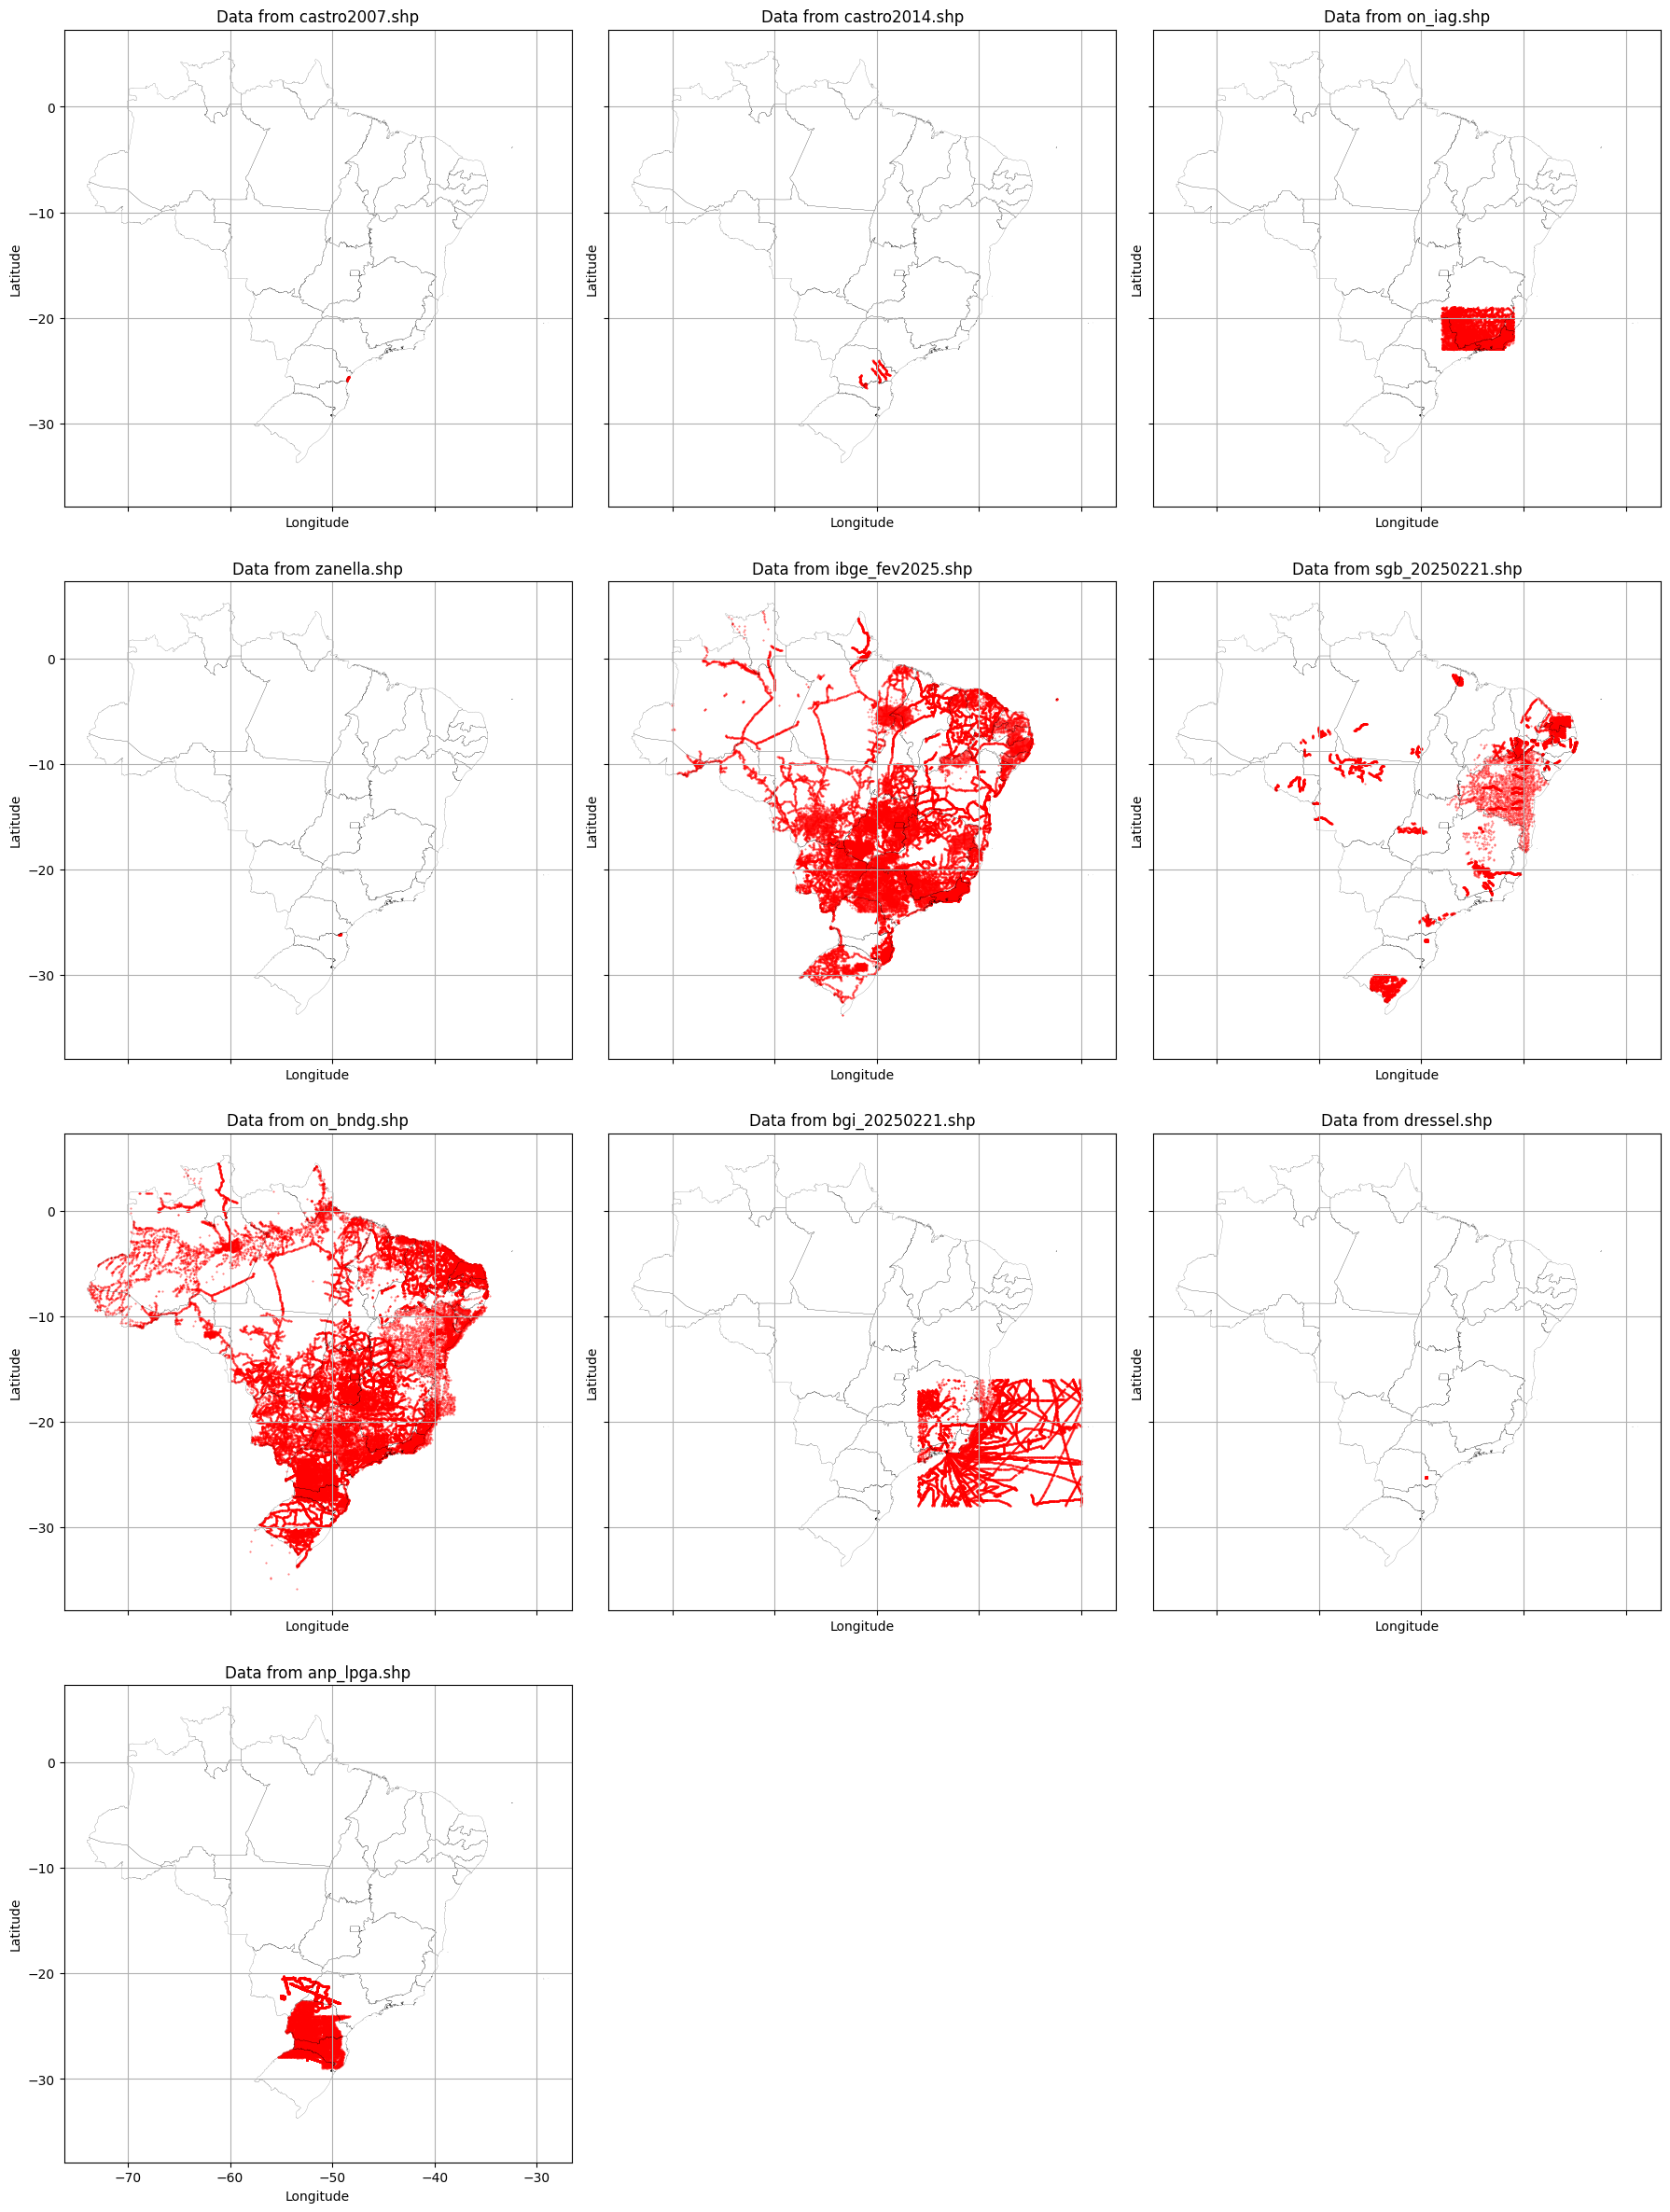

In [ ]:
# Plotar os dados dos shapefiles

import pandas as pd
import matplotlib.pyplot as plt
import glob

# Brasil shapefile
brasil_shp_path = '/content/brasil_shapefile/BR_UF_2021.shp'

if not os.path.exists(brasil_shp_path):
  print(f"Brasil shapefile not found at {brasil_shp_path}. Please upload it or adjust the path.")
else:
  brasil_contour = gpd.read_file(brasil_shp_path)
  brasil_contour = brasil_contour.to_crs("EPSG:4326") # WGS84

  # Ler todos os dados
  all_grav_dfs = []

  shp_files_in_dir = glob.glob(os.path.join(extract_dir, '*.shp'))
  print(f"Found {len(shp_files_in_dir)} shapefiles in {extract_dir}")

  if not shp_files_in_dir:
      print("No shapefiles found in the extraction directory.")
  else:
      for shp_file in shp_files_in_dir:
          try:
              gdf = gpd.read_file(shp_file)
              if 'LATITUDE' in gdf.columns and 'LONGITUDE' in gdf.columns:

                  # Criar a geometria se ela não existir
                  if gdf.geometry.isnull().all():
                      gdf['geometry'] = gpd.points_from_xy(gdf['LONGITUDE'], gdf['LATITUDE'])

                  if gdf.crs is None:
                      gdf = gdf.set_crs("EPSG:4326")
                      print(f"Set CRS to EPSG:4326 for {os.path.basename(shp_file)}")
                  else:
                      if gdf.crs.to_epsg() != 4326:
                           gdf = gdf.to_crs("EPSG:4326")
                           print(f"Reprojected {os.path.basename(shp_file)} to EPSG:4326")

                  # Add source filename for tracking
                  gdf['source_file'] = os.path.basename(shp_file)
                  all_grav_dfs.append(gdf)
                  print(f"Processed {os.path.basename(shp_file)}")
              else:
                  print(f"Skipping {os.path.basename(shp_file)}: Missing LATITUDE or LONGITUDE columns.")
          except Exception as e:
              print(f"Error processing {os.path.basename(shp_file)}: {e}")

      if not all_grav_dfs:
          print("No valid shapefiles with Latitude and Longitude found for plotting.")
      else:
          # Determine the number of subplots
          n_files = len(all_grav_dfs)
          n_cols = 3  # Or adjust based on desired layout
          n_rows = (n_files + n_cols - 1) // n_cols

          fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6), sharex=True, sharey=True)
          # Flatten axes array for easy iteration if it's a 2D array
          if n_rows > 1 or n_cols > 1:
              axes = axes.flatten()
          else:
              axes = [axes] # Ensure axes is iterable even for a single plot

          for i, gdf in enumerate(all_grav_dfs):
              ax = axes[i]
              source_file = gdf['source_file'].iloc[0] if not gdf.empty else "Unknown Source"

              # Plot the gravity points
              if not gdf.empty:
                  # Ensure LATITUDE and LONGITUDE are numeric, convert errors to NaN and drop
                  gdf['LATITUDE'] = pd.to_numeric(gdf['LATITUDE'], errors='coerce')
                  gdf['LONGITUDE'] = pd.to_numeric(gdf['LONGITUDE'], errors='coerce')
                  gdf.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

                  if not gdf.empty:
                      gdf.plot(ax=ax, color='red', markersize=0.2, alpha=0.6)
                  else:
                      print(f"No valid points found after converting to numeric in {source_file}")

              # Plot Brasil contour
              brasil_contour.plot(ax=ax, color='none', edgecolor='black', linewidth=0.1)

              ax.set_title(f'Data from {source_file}')
              ax.set_xlabel('Longitude')
              ax.set_ylabel('Latitude')
              ax.grid(True)

          # Turn off any unused subplots
          for j in range(i + 1, len(axes)):
              fig.delaxes(axes[j])

          plt.tight_layout()
          plt.show()

Combinar em um único objeto tipo gdf

In [ ]:
# Ler e concatenar objetos gdf
gdf_list = []
for shp_path, source_name in shapefiles:
    gdf = gpd.read_file(shp_path)

    # Garantir que todos os shapefiles usem o CRS SIRGAS 2000
    if gdf.crs is None:
        gdf.set_crs("EPSG:4674", inplace=True)
    else:
        gdf = gdf.to_crs("EPSG:4674")

    # Salvar o nome do arquivo zip no objeto
    gdf['source_file'] = source_name
    gdf_list.append(gdf)

# Combinar
combined_gdf = pd.concat(gdf_list, ignore_index=True)

# Total de registros em combined_gdf:
print(f"Total de registros combinados: {len(combined_gdf)}")

combined_gdf

Total de registros combinados: 378714


,Line,LONGITUDE,LATITUDE,ALT_ORT,GRAV_OBS,FONTE,geometry,source_file,ALT_GEO,ALT_NOR,ID,GeosoftLin,FA,BOUGUER,LINE,INSTITUICA
0,Gravimetria_CPRM_2022_vr1,-62.155065,-11.186133,238.14,978167.79,SGB-CPRM,POINT (-62.15507 -11.18613),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gravimetria_CPRM_2022_vr1,-62.15511,-11.195567,232.07,978167.09,SGB-CPRM,POINT (-62.15511 -11.19557),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gravimetria_CPRM_2022_vr1,-62.15496,-11.205559,214.83,978168.31,SGB-CPRM,POINT (-62.15496 -11.20556),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gravimetria_CPRM_2022_vr1,-62.155118,-11.214858,240.39,978163.82,SGB-CPRM,POINT (-62.15512 -11.21486),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gravimetria_CPRM_2022_vr1,-62.161604,-11.221462,218.33,978165.31,SGB-CPRM,POINT (-62.1616 -11.22146),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378709,L15102,-45.13,-22.74,530.0,978610.27,NaN,POINT (-45.1337 -22.7446),/content/on_iag.zip,NaN,NaN,NaN,NaN,-30.31,-89.62,NaN,UFO
378710,L15102,-45.15,-22.77,540.0,978612.64,NaN,POINT (-45.1492 -22.7687),/content/on_iag.zip,NaN,NaN,NaN,NaN,-26.41,-86.84,NaN,UFO
378711,L15102,-45.16,-22.78,545.0,978615.91,NaN,POINT (-45.1598 -22.7822),/content/on_iag.zip,NaN,NaN,NaN,NaN,-22.47,-83.45,NaN,UFO
378712,L15102,-45.17,-22.8,545.0,978623.15,NaN,POINT (-45.1732 -22.805),/content/on_iag.zip,NaN,NaN,NaN,NaN,-16.7,-77.68,NaN,UFO


Verificar pontos duplicados, com base nos campos LATITUDE e LONGITUDE. Está sendo considerado que o valor da coordenada arredondado em 8 casas possui precisão suficiente.

In [ ]:
combined_gdf['LATITUDE'] = combined_gdf['LATITUDE'].round(8) #precisão da coordenada
combined_gdf['LONGITUDE'] = combined_gdf['LONGITUDE'].round(8)

# Masking duplicates
duplicated_mask = combined_gdf.duplicated(subset=['LATITUDE', 'LONGITUDE'], keep='first')
duplicated_gdf = combined_gdf[duplicated_mask] # True values
unique_gdf = combined_gdf[~duplicated_mask] #False values


# Total de registros em duplicated_gdf:
print("Total de registros duplicados:", len(duplicated_gdf))
# Total de registros em unique_gdf:
print("Total de registros não-duplicados:", len(unique_gdf))

Total de registros duplicados: 140821
Total de registros não-duplicados: 237893


Plotar os mapas de todos os dados no mapa do Brasil

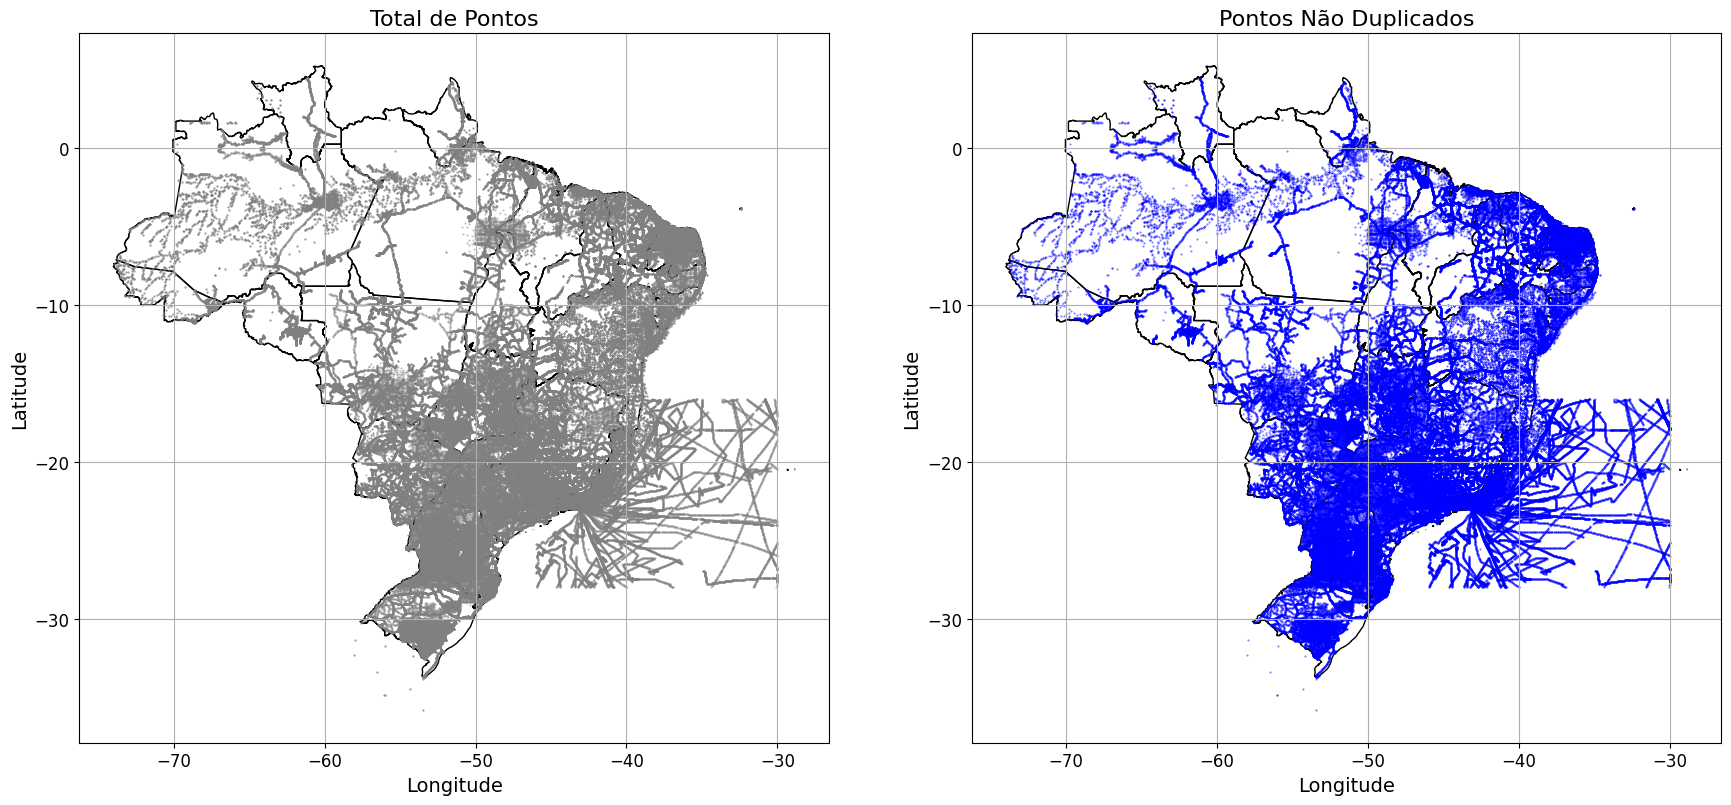

In [ ]:
plot_2maps(
    gdf1=combined_gdf, title1='Total de Pontos', color1='grey',
    gdf2=unique_gdf, title2='Pontos Não Duplicados', color2='blue',
    brasil_contour=brasil
)

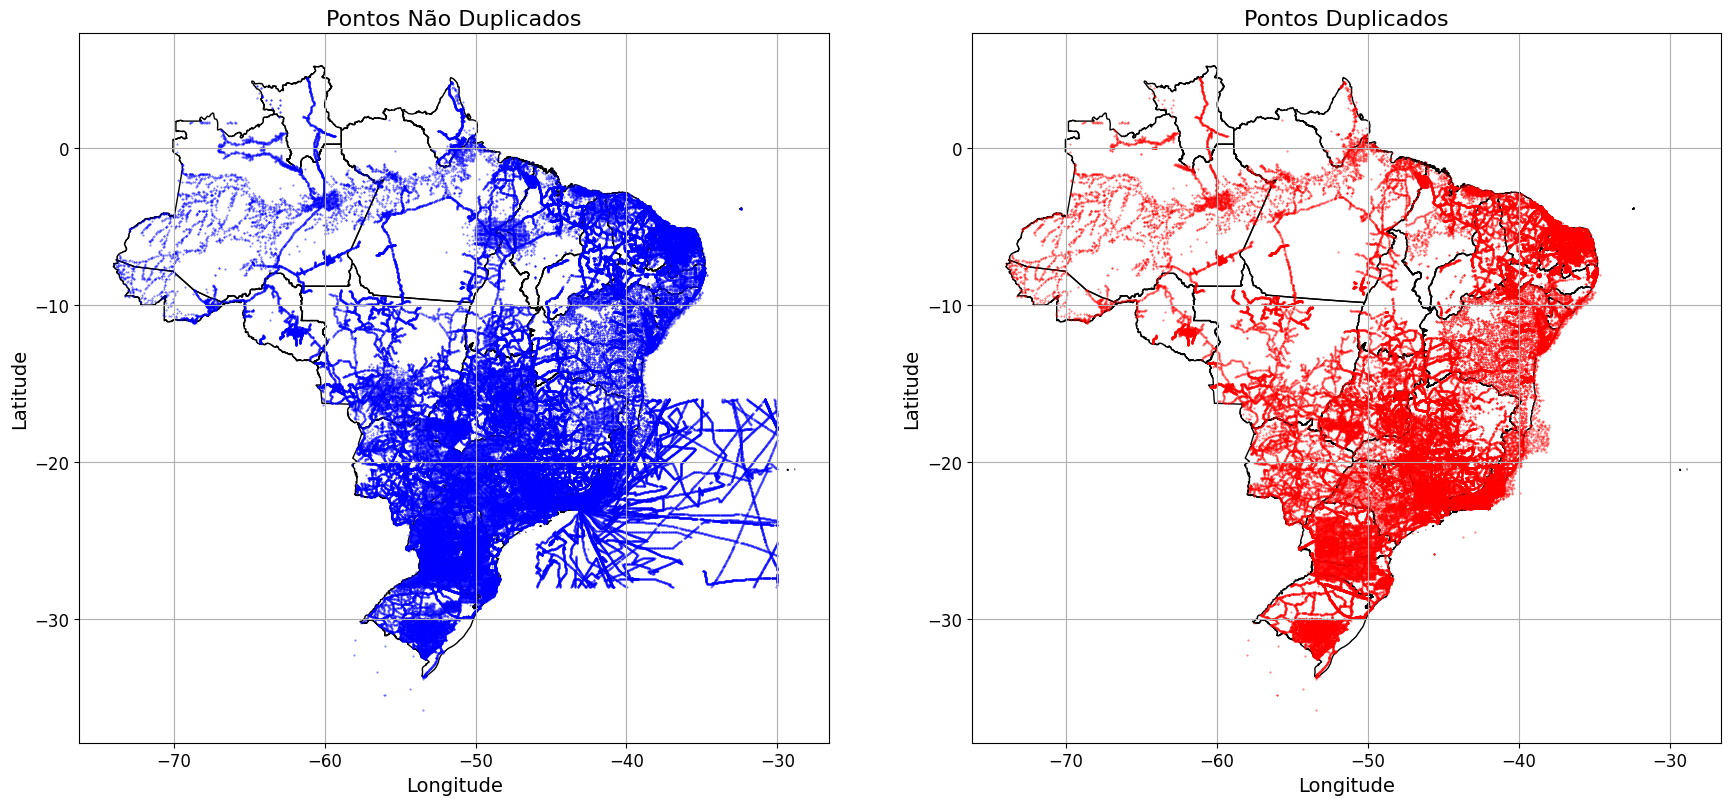

In [ ]:
plot_2maps(
    gdf1=unique_gdf, title1='Pontos Não Duplicados', color1='blue',
    gdf2=duplicated_gdf, title2='Pontos Duplicados', color2='red',
    brasil_contour=brasil
)

#####**Correção de caracteres**

In [ ]:
# Erros de digitacao ou multiplos pontos, ou virgula para marcar decimal
unique_gdf['GRAV_OBS'] = unique_gdf['GRAV_OBS'].astype(str).apply(correct_grav_obs_value)

print(unique_gdf['GRAV_OBS'].head(10))

# Convertendo a coluna 'GRAV_OBS' para numérico
unique_gdf['GRAV_OBS'] = pd.to_numeric(unique_gdf['GRAV_OBS'], errors='coerce')

unique_gdf

0    978167.79
1    978167.09
2    978168.31
3    978163.82
4    978165.31
5    978170.00
6    978170.73
7    978171.53
8    978170.48
9    978169.67
Name: GRAV_OBS, dtype: float64


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Line,LONGITUDE,LATITUDE,ALT_ORT,GRAV_OBS,FONTE,geometry,source_file,ALT_GEO,ALT_NOR,ID,GeosoftLin,FA,BOUGUER,LINE,INSTITUICA
0,Gravimetria_CPRM_2022_vr1,-62.155065,-11.186133,238.14,978167.79,SGB-CPRM,POINT (-62.15507 -11.18613),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gravimetria_CPRM_2022_vr1,-62.15511,-11.195567,232.07,978167.09,SGB-CPRM,POINT (-62.15511 -11.19557),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gravimetria_CPRM_2022_vr1,-62.15496,-11.205559,214.83,978168.31,SGB-CPRM,POINT (-62.15496 -11.20556),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gravimetria_CPRM_2022_vr1,-62.155118,-11.214858,240.39,978163.82,SGB-CPRM,POINT (-62.15512 -11.21486),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gravimetria_CPRM_2022_vr1,-62.161604,-11.221462,218.33,978165.31,SGB-CPRM,POINT (-62.1616 -11.22146),/content/bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271971,LANP,-51.8627,-23.523353,448.786,978687.06,ANP,POINT (-51.8627 -23.52335),/content/anp_lpga.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271972,LANP,-51.8669,-23.466743,574.668,978660.32,ANP,POINT (-51.8669 -23.46674),/content/anp_lpga.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271973,LANP,-51.8606,-23.418243,508.098,978670.20,ANP,POINT (-51.8606 -23.41824),/content/anp_lpga.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271974,LANP,-51.8675,-23.252832,489.323,978666.35,ANP,POINT (-51.8675 -23.25283),/content/anp_lpga.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# valores "*" por nan em unique_gdf, e quantos valores foram substituidos

initial_nan_count = unique_gdf.isnull().sum().sum()
unique_gdf.replace('*', np.nan, inplace=True)
final_nan_count = unique_gdf.isnull().sum().sum()

replaced_count = final_nan_count - initial_nan_count

print(f"Number of '*' values replaced with NaN: {replaced_count}")

Number of '*' values replaced with NaN: 315


/tmp/ipython-input-66-2375093535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_gdf.replace('*', np.nan, inplace=True)


Manter no objeto geopandas apenas as colunas necessárias (coordenadas, gravidade, e altitude ortométrica)

In [ ]:
columns_to_keep = ['LATITUDE', 'LONGITUDE', 'GRAV_OBS', 'ALT_ORT', 'source_file', 'geometry']
unique_gdf = unique_gdf[columns_to_keep]
missing_columns = [col for col in columns_to_keep if col not in unique_gdf.columns]

if missing_columns:
    print(f"As seguintes colunas estão faltando: {missing_columns}")
else:
    print("\nDados filtrados com as colunas desejadas:")
    print(unique_gdf.head(10))

# Assegurar que as colunas de números estão como tipo número
unique_gdf['LONGITUDE'] = pd.to_numeric(unique_gdf['LONGITUDE'])
unique_gdf['LATITUDE'] = pd.to_numeric(unique_gdf['LATITUDE'])
unique_gdf['GRAV_OBS'] = pd.to_numeric(unique_gdf['GRAV_OBS'])
unique_gdf['ALT_ORT'] = pd.to_numeric(unique_gdf['ALT_ORT'])

# Exibir amostra dos dados
print(f"\nNúmero de linhas no GeoDataFrame: {len(unique_gdf)}")
print(f"\nNúmero de valores inválidos por coluna:")
unique_gdf.isna().sum()


Dados filtrados com as colunas desejadas:
    LATITUDE  LONGITUDE   GRAV_OBS ALT_ORT                source_file  \
0 -11.186133 -62.155065  978167.79  238.14  /content/bgi_20250221.zip   
1 -11.195567  -62.15511  978167.09  232.07  /content/bgi_20250221.zip   
2 -11.205559  -62.15496  978168.31  214.83  /content/bgi_20250221.zip   
3 -11.214858 -62.155118  978163.82  240.39  /content/bgi_20250221.zip   
4 -11.221462 -62.161604  978165.31  218.33  /content/bgi_20250221.zip   
5  -11.22397 -62.169878  978170.00   195.5  /content/bgi_20250221.zip   
6 -11.226232 -62.177596  978170.73  189.93  /content/bgi_20250221.zip   
7 -11.230456 -62.186101  978171.53  183.98  /content/bgi_20250221.zip   
8 -11.237466 -62.193176  978170.48  182.03  /content/bgi_20250221.zip   
9 -11.240136 -62.200686  978169.67  180.46  /content/bgi_20250221.zip   

                      geometry  
0  POINT (-62.15507 -11.18613)  
1  POINT (-62.15511 -11.19557)  
2  POINT (-62.15496 -11.20556)  
3  POINT (-62.15512 -

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,0
LATITUDE,0
LONGITUDE,0
GRAV_OBS,0
ALT_ORT,105
source_file,0
geometry,0


**Salvar o shapefile do concatenado total (antes do corte):**

In [ ]:
# Salvar dados resultantes como shapefiles
output_dir = '/content/OUTPUT'
os.makedirs(output_dir, exist_ok=True)

unique_gpd = gpd.GeoDataFrame(unique_gdf, geometry=gpd.points_from_xy(unique_gdf.LONGITUDE, unique_gdf.LATITUDE))
unique_gpd.set_crs("EPSG:4674", inplace=True) # deixar como CRS SIRGAS 2000

# Salvar o shapefile editado
output_path = '/content/OUTPUT/grav_concatenado_geograficasirgas2000.shp'
unique_gpd.to_file(output_path)

print("Dado editado salvo em grav_concatenado.shp")

shutil.make_archive('/content/grav_concatenado_geograficasirgas2000', 'zip', output_dir)

from google.colab import files
files.download('/content/grav_concatenado_geograficasirgas2000.zip')

/tmp/ipython-input-69-4038384762.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  unique_gpd.to_file(output_path)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'source_file' to 'source_fil'
  ogr_write(


Dado editado salvo em grav_concatenado.shp


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Recortar e salvar o shapefile do dado concatenado recortado:**

In [ ]:
# Salvar dados resultantes como shapefiles
grav_gdf = unique_gdf.copy()
output_dir = '/content/OUTPUT'

grav_gpd = gpd.GeoDataFrame(grav_gdf, geometry=gpd.points_from_xy(unique_gdf.LONGITUDE, unique_gdf.LATITUDE))
grav_gpd.set_crs("EPSG:4674", inplace=True) # deixar como CRS SIRGAS 2000

#Recorte
aoi_gdf = aoi_gdf.to_crs(grav_gpd.crs)
aoi_gpd = gpd.GeoDataFrame(aoi_gdf, geometry=aoi_gdf.geometry)

grav_gpd = gpd.clip(grav_gpd, aoi_gdf)
grav_gpd = grav_gpd.reset_index(drop=True)

# Salvar o shapefile editado
output_path = '/content/OUTPUT/grav_recortado_geograficasirgas2000.shp'
grav_gpd.to_file(output_path)

print(f"Dado editado salvo em {output_path}")

shutil.make_archive('/content/grav_recortado_geograficasirgas2000', 'zip', output_dir)

from google.colab import files
files.download('/content/grav_recortado_geograficasirgas2000.zip')

/tmp/ipython-input-46-150827423.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grav_gpd.to_file(output_path)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'source_file' to 'source_fil'
  ogr_write(


Dado editado salvo em /content/OUTPUT/grav_recortado_geograficasirgas2000.shp


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: >

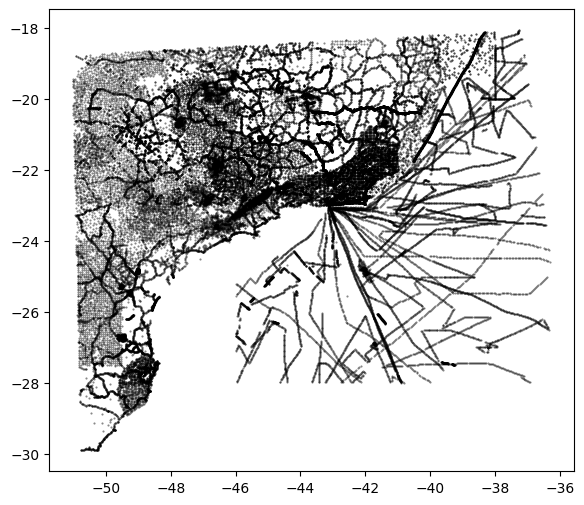

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
grav_gpd.plot(ax=ax, color='black', alpha=0.5, markersize = 0.25)

## **1.2 Obter topografia para o estudo**
Obter dados usando a biblioteca pystac-client.


###### Verificar variáveis da AOI

In [ ]:
aoi_gdf_wgs84

,geometry
0,"POLYGON ((-50.78218 -30.013, -35.7111 -28.8158..."


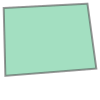

In [ ]:
aoi_gdf_wgs84_geom

###### Conectar-se ao catálogo STAC e fazer a busca na coleção cop-dem-glo-30

In [ ]:
import pystac_client
from pystac_client import Client

# Conectar-se ao catálogo STAC do Planetary Computer
catalog_url = 'https://planetarycomputer.microsoft.com/api/stac/v1'
#client = pystac_client.Client.open(catalog_url)
catalog = Client.open(catalog_url)
print(catalog.title, catalog.description)

Microsoft Planetary Computer STAC API Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [ ]:
from shapely.geometry import shape, mapping

aoi_buffer = aoi_gdf_wgs84_geom.buffer(0.1) # aplicar um buffer de 0.1 grau (~10 km)
aoi_gdf_wgs84_geom_buffer = mapping(aoi_buffer)# GeoJSON para consulta STAC

# Fazer busca
search = catalog.search(
    collections=["cop-dem-glo-30"],
    intersects=aoi_gdf_wgs84_geom_buffer,
    max_items=100
)

items = list(search.items())
print(f"✅ {len(items)} tiles encontrados com buffer.") if items else print("❌ Nenhum item encontrado.")


✅ 97 tiles encontrados com buffer.


In [ ]:
# Informações dos tiles obtidos
tile_info = []

for item in items:
    props = item.properties
    tile_info.append({
        "id": item.id,
        "datetime": props.get("datetime"),
        "bbox": item.bbox,
        "epsg": props.get("proj:epsg"),
        "geometry_type": item.geometry['type']
    })

df_tiles = pd.DataFrame(tile_info)
print(df_tiles.head())

                                         id              datetime  \
0  Copernicus_DSM_COG_10_S31_00_W051_00_DEM  2021-04-22T00:00:00Z   
1  Copernicus_DSM_COG_10_S30_00_W051_00_DEM  2021-04-22T00:00:00Z   
2  Copernicus_DSM_COG_10_S30_00_W050_00_DEM  2021-04-22T00:00:00Z   
3  Copernicus_DSM_COG_10_S29_00_W051_00_DEM  2021-04-22T00:00:00Z   
4  Copernicus_DSM_COG_10_S29_00_W050_00_DEM  2021-04-22T00:00:00Z   

                                                bbox  epsg geometry_type  
0  [-51.00013888888889, -30.999861111111112, -50....  None       Polygon  
1  [-51.00013888888889, -29.999861111111112, -50....  None       Polygon  
2  [-50.00013888888889, -29.999861111111112, -49....  None       Polygon  
3  [-51.00013888888889, -28.999861111111112, -50....  None       Polygon  
4  [-50.00013888888889, -28.999861111111112, -49....  None       Polygon  


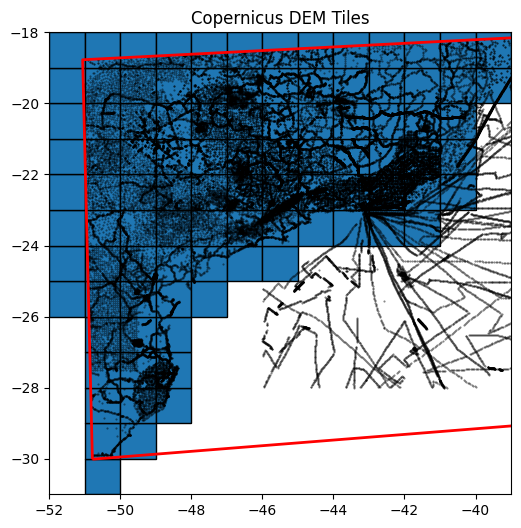

In [ ]:
# Criar GeoDataFrames dos footprints dos items
geoms = [shape(item.geometry) for item in items]
gdf = gpd.GeoDataFrame({
    "id": [item.id for item in items],
    "datetime": [item.properties.get("datetime") for item in items],
    "epsg": [item.properties.get("proj:epsg") for item in items]
}, geometry=geoms, crs="EPSG:4326")

# Plotar localização das imagens encontradas
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, legend=True, edgecolor='black')
aoi_gdf.to_crs(gdf.crs)
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
grav_gpd.plot(ax=ax, color='black', alpha=0.5, markersize = 0.25)
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
plt.title("Copernicus DEM Tiles")
plt.show()

###### Baixar os tiles selecionados - Mosaicar - Salvar como tif com compressão

In [ ]:
# Baixar os tiles selecionados e mosaicar
from planetary_computer import sign

os.makedirs("/content/tiles", exist_ok=True)

for item in items:
    try:
        signed_item = sign(item)
        url = signed_item.assets["data"].href
        tile_id = item.id.replace(":", "_")
        out_path = f"/content/tiles/{tile_id}.tif"

        if not os.path.exists(out_path):
            print(f"⬇️ Baixando: {tile_id}")
            response = requests.get(url, stream=True)
            with open(out_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        else:
            print(f"✔️ Já existe: {tile_id}")
    except Exception as e:
        print(f"⚠️ Falha ao baixar {item.id}: {e}")

# Mosaico
!gdal_merge.py -o /content/ribeira-campos_copernicus.tif -of GTiff /content/tiles/*.tif

# Compressão
!gdal_translate /content/ribeira-campos_copernicus.tif \
  /content/ribeira-campos_copernicus_compressed.tif \
  -co COMPRESS=DEFLATE -co TILED=YES

⬇️ Baixando: Copernicus_DSM_COG_10_S31_00_W051_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S30_00_W051_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S30_00_W050_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S29_00_W051_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S29_00_W050_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S29_00_W049_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S28_00_W051_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S28_00_W050_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S28_00_W049_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S27_00_W051_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S27_00_W050_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S27_00_W049_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S26_00_W052_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S26_00_W051_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S26_00_W050_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S26_00_W049_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S26_00_W048_00_DEM
⬇️ Baixando: Copernicus_DSM_COG_10_S25_00_W052_00_DEM
⬇️ Baixando: Copernicus_DSM_

###### Escrever arquivo TIF de saída com economia de recursos (em blocos)

In [ ]:
from rasterio.windows import Window

input_path = "/content/ribeira-campos_copernicus_compressed.tif"
output_path = "/content/ribeira-campos_copernicus_onshore.tif"

with rasterio.open(input_path) as src:
    profile = src.profile.copy()
    profile.update(
        nodata=-9999,
        compress='deflate',
        tiled=True,
        blockxsize=256,
        blockysize=256
    )

    with rasterio.open(output_path, 'w', **profile) as dst:
        for ji, window in src.block_windows(1):
            block = src.read(1, window=window)
            block_masked = np.where(block >= 0, block, -9999)
            dst.write(block_masked, 1, window=window)

/tmp/ipython-input-79-144184400.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grav_gdf.to_file(output_path_clipped)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'source_file' to 'source_fil'
  ogr_write(


Dado recortado salvo em /content/OUTPUT/grav_recortado_geograficasirgas2000.shp


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

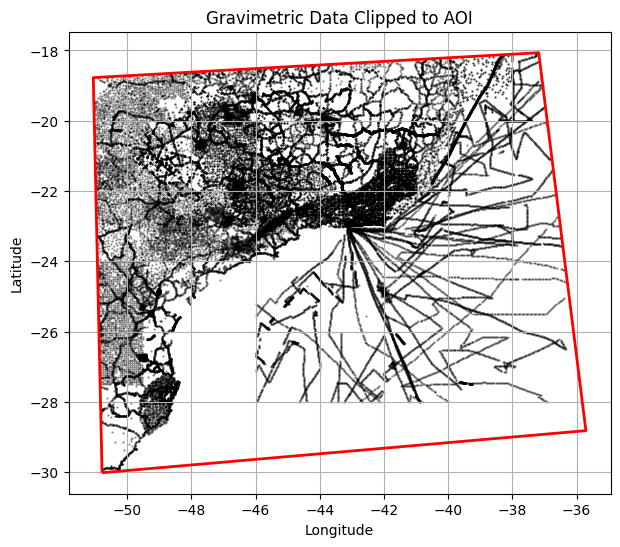

In [ ]:
# Ensure aoi_gdf and grav_gpd are in the same CRS before clipping
aoi_gdf = aoi_gdf.to_crs(grav_gdf.crs)

# Perform the clip operation
grav_clipped_gdf = gpd.clip(grav_gdf, aoi_gdf)
grav_gdf = grav_clipped_gdf.reset_index(drop=True)

# Salvar o shapefile editado (clipped)
output_dir = '/content/OUTPUT'
os.makedirs(output_dir, exist_ok=True)
output_path_clipped = '/content/OUTPUT/grav_recortado_geograficasirgas2000.shp'
grav_gdf.to_file(output_path_clipped)

print(f"Dado recortado salvo em {output_path_clipped}")

shutil.make_archive('/content/grav_recortado_geograficasirgas2000', 'zip', output_dir)

files.download('/content/grav_recortado_geograficasirgas2000.zip')

# Plot the clipped data
fig, ax = plt.subplots(figsize=(10, 6))
if not grav_gdf.empty:
    grav_gdf.plot(ax=ax, color='black', alpha=0.5, markersize=0.25)
else:
    print("No points found within the AOI after clipping.")

# Optionally, plot the AOI boundary on the same map
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

ax.set_title('Gravimetric Data Clipped to AOI')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)
plt.show()


Adicionar valores do DEM COP30 ao gdf

In [ ]:
# Obter valores do DEM
dem_path = "/content/ribeira-campos_copernicus_compressed.tif"
with rasterio.open(dem_path) as dem:
    if grav_gdf.crs != dem.crs:
      print(f"DEM CRS:{dem.crs}")
      print(f"Grav CRS:{grav_gdf.crs}")
      grav_gdf = grav_gdf.to_crs(dem.crs)
      print(f"   grav_gdf.to_crs(dem.crs):{grav_gdf.crs}")
    coords = [(pt.x, pt.y) for pt in grav_gdf.geometry] # usa geometria para amostrar
    alt_vals = np.array([v[0] for v in dem.sample(coords)], dtype=np.float32)
    # nodata → NaN
    if dem.nodata is not None:
      alt_vals[alt_vals == dem.nodata] = np.nan

grav_gdf["ALT_ORTCO"] = alt_vals
grav_gdf.loc[grav_gdf["ALT_ORTCO"] <= 0, "ALT_ORTCO"] = np.nan

# Salvar backup
grav_gdf.to_file("/content/grav_gdf_copernicus.gpkg", driver="GPKG")

grav_gdf

DEM CRS:EPSG:4326
Grav CRS:EPSG:4674
   grav_gdf.to_crs(dem.crs):GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


,LATITUDE,LONGITUDE,GRAV_OBS,ALT_ORT,source_file,geometry,ALT_ORTCO
0,-29.90910,-50.76490,979284.86,40.74,/content/on_bndg.zip,POINT (-50.7649 -29.9091),40.539581
1,-29.90860,-50.76440,979284.86,40.74,/content/on_bndg.zip,POINT (-50.7644 -29.9086),37.926083
2,-29.90776,-50.75933,979285.39,0.00,/content/ibge.zip,POINT (-50.75933 -29.90776),37.795368
3,-29.89600,-50.73380,979287.15,21.23,/content/on_bndg.zip,POINT (-50.7338 -29.896),23.904009
4,-29.89560,-50.73330,979287.15,21.23,/content/on_bndg.zip,POINT (-50.7333 -29.8956),22.039808
...,...,...,...,...,...,...,...
69160,-18.17900,-37.35430,978545.30,1783.00,/content/bgi_20250221.zip,POINT (-37.3543 -18.179),NaN
69161,-18.17320,-37.33200,978544.30,1710.00,/content/bgi_20250221.zip,POINT (-37.332 -18.1732),NaN
69162,-18.23580,-37.56350,978557.30,1435.00,/content/bgi_20250221.zip,POINT (-37.5635 -18.2358),NaN
69163,-18.23030,-37.54150,978552.30,1390.00,/content/bgi_20250221.zip,POINT (-37.5415 -18.2303),NaN


In [ ]:
# Download
files.download("/content/grav_gdf_copernicus.gpkg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **2.3 Obter batimetria**

In [ ]:
# prompt: download zip file from https://www.marinha.mil.br/dhn/sites/www.marinha.mil.br.dhn/files/DTM_Brasil_LatLongProf.zip  and unzip

url = "https://www.marinha.mil.br/dhn/sites/www.marinha.mil.br.dhn/files/DTM_Brasil_LatLongProf.zip"
output_filename = "DTM_Brasil_LatLongProf.zip"
output_dir = "/content/DTM_Brasil_LatLongProf" # Directory to unzip into

# Download the zip file
print(f"Downloading {url}...")
try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
    with open(output_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"Downloaded {output_filename} successfully.")

    # Unzip the file
    print(f"Unzipping {output_filename} to {output_dir}...")
    os.makedirs(output_dir, exist_ok=True)
    with zipfile.ZipFile(output_filename, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print("Unzipping complete.")

except requests.exceptions.RequestException as e:
    print(f"Error during download or unzip: {e}")
except zipfile.BadZipFile:
    print(f"Error: The downloaded file {output_filename} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



Downloaded DTM_Brasil_LatLongProf.zip successfully.
Unzipping DTM_Brasil_LatLongProf.zip to /content/DTM_Brasil_LatLongProf...
Unzipping complete.


In [ ]:
df_bathymetry = pd.read_csv(
    '/content/DTM_Brasil_LatLongProf/DTM_Brasil_MAR21_1000m.XYZ',
    sep='\s+', #delim_whitespace=True, # whitespace delimiter
    names=['LONGITUDE', 'LATITUDE', 'BAT']
)

# Create a GeoDataFrame
geometry = gpd.points_from_xy(df_bathymetry['LONGITUDE'], df_bathymetry['LATITUDE'])
gdf_bathymetry = gpd.GeoDataFrame(df_bathymetry, geometry=geometry, crs=crs_projeto)

print("Batimetria GeoDataFrame criado:")
print(gdf_bathymetry.head())


/tmp/ipython-input-118-295654118.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bathymetry = pd.read_csv(


Batimetria GeoDataFrame criado:
   LONGITUDE   LATITUDE     BAT               geometry
0 -37.499877 -47.475963 -5102.6  POINT (-37.5 -47.476)
1 -37.499877 -47.466980 -5102.7  POINT (-37.5 -47.467)
2 -37.499877 -47.457996 -5103.0  POINT (-37.5 -47.458)
3 -37.499877 -47.449013 -5103.1  POINT (-37.5 -47.449)
4 -37.499877 -47.440030 -5103.5   POINT (-37.5 -47.44)


In [ ]:
def estimate_bathymetry(grav_gdf_row, gdf_bathymetry, window_size_km=5):
    """
    Estimates the bathymetry (BAT) for a gravimetric point by averaging
    nearby bathymetry points within a given window size.

    Args:
        grav_gdf_row (pd.Series): A single row from the grav_gdf where ALT_ORTCO is NaN.
                                 Should contain 'LONGITUDE' and 'LATITUDE'.
        gdf_bathymetry (gpd.GeoDataFrame): The GeoDataFrame containing bathymetry points
                                         with 'LONGITUDE', 'LATITUDE', and 'BAT' columns.
        window_size_km (int): The radius in kilometers to search for nearby bathymetry points.

    Returns:
        float: The estimated bathymetry value (average of nearby points), or np.nan
               if no nearby bathymetry points are found within the window.
    """
    grav_lon = grav_gdf_row['LONGITUDE']
    grav_lat = grav_gdf_row['LATITUDE']

    # Calculate distances to all bathymetry points
    # Ensure both dataframes have the correct coordinate columns and are numeric
    gdf_bathymetry['LONGITUDE'] = pd.to_numeric(gdf_bathymetry['LONGITUDE'], errors='coerce')
    gdf_bathymetry['LATITUDE'] = pd.to_numeric(gdf_bathymetry['LATITUDE'], errors='coerce')
    gdf_bathymetry = gdf_bathymetry.dropna(subset=['LONGITUDE', 'LATITUDE'])


    distances = gdf_bathymetry.apply(
        lambda row: haversine(grav_lon, grav_lat, row['LONGITUDE'], row['LATITUDE']),
        axis=1
    )

    # Filter for bathymetry points within the window size
    nearby_bat_points = gdf_bathymetry[distances <= window_size_km]

    # Estimate bathymetry by averaging, if points are found
    if not nearby_bat_points.empty:
        # Ensure 'BAT' column is numeric, coercing errors to NaN and dropping
        nearby_bat_points['BAT'] = pd.to_numeric(nearby_bat_points['BAT'], errors='coerce')
        nearby_bat_points = nearby_bat_points.dropna(subset=['BAT'])

        if not nearby_bat_points.empty:
             # We take the average of the 'BAT' values
            estimated_bat = nearby_bat_points['BAT'].mean()
            return estimated_bat
        else:
             return np.nan # No valid numeric 'BAT' values found in nearby points
    else:
        return np.nan # No nearby bathymetry points found

grav_gdf['BAT'] = np.nan
nan_alt_mask = grav_gdf['ALT_ORTCO'].isna()
# subset of the grav_gdf where ALT_ORTCO is NaN
grav_gdf.loc[nan_alt_mask, 'BAT'] = grav_gdf.loc[nan_alt_mask].apply(
    lambda row: estimate_bathymetry(row, gdf_bathymetry, window_size_km=5), axis=1
)

print("\nGrav_gdf with estimated BAT values:")
print(grav_gdf[['LONGITUDE', 'LATITUDE', 'ALT_ORTCO', 'BAT']].head())

grav_gdf['ALT'] = grav_gdf['ALT_ORTCO'].fillna(-grav_gdf['BAT'])
print(grav_gdf.head())